In [ ]:
from datetime import datetime, timedelta
from sqlmodel import Field, Relationship, SQLModel, Session, create_engine, select, col

CYCLE_TIME = 1      # times in hours
db_name = "beboundless_data.db"
sqlite_url = f"sqlite:///{db_name}"
engine = create_engine(sqlite_url)

In [ ]:
from beboundless_data_db import Requestors, Orders

one_hour_ago = int((datetime.now() - timedelta(hours=CYCLE_TIME)).timestamp())
with Session(engine) as session:
    statement = select(Requestors).where(Requestors.last_activity >= one_hour_ago)
    results: list[Requestors] = session.exec(statement).all()

address = [r.address for r in results if r.address]
print(address)

data_dict = {}
with Session(engine) as session:
    for addr in address:
        statement = select(Orders).where(
            Orders.created >= one_hour_ago,
            Orders.requestor_address == addr,
            Orders.lock_gas_price != None
        )
        orders = session.exec(statement).all()
        data_dict[addr] = [(order.order_id, order.lock_txn, order.lock_gas_price) for order in orders if order.lock_gas_price]
print(data_dict)

['0x2546c553d857d20658ece248f7c7d0861a240681', '0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0', '0x89f12aba0bcda3e708b1129eb2557b96f57b0de6', '0x734df7809c4ef94da037449c287166d114503198', '0xf353bda16a83399c11e09615ee7ac326a5a08ccf']


Group stats:
                                      address  count      mean       std  \
0  0x2546c553d857d20658ece248f7c7d0861a240681     39  0.098772  0.066164   
1  0x734df7809c4ef94da037449c287166d114503198      1  6.858063       NaN   
2  0x89f12aba0bcda3e708b1129eb2557b96f57b0de6      2  2.331575  0.171934   
3  0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0     34  0.507951  0.341036   
4  0xf353bda16a83399c11e09615ee7ac326a5a08ccf      3  0.133427  0.187639   

        min       max    median       q25       q75 best_range  
0  0.001570  0.300259  0.100044  0.050275  0.109000  0.05~0.11  
1  6.858063  6.858063  6.858063  6.858063  6.858063  6.86~6.86  
2  2.210000  2.453151  2.331575  2.270788  2.392363  2.27~2.39  
3  0.001563  0.750950  0.750346  0.042538  0.750643  0.04~0.75  
4  0.025092  0.350093  0.025095  0.025093  0.187594  0.03~0.19  
Good suppliers:
                                      address  count      mean       std  \
0  0x2546c553d857d20658ece248f7c7d0861a240681   

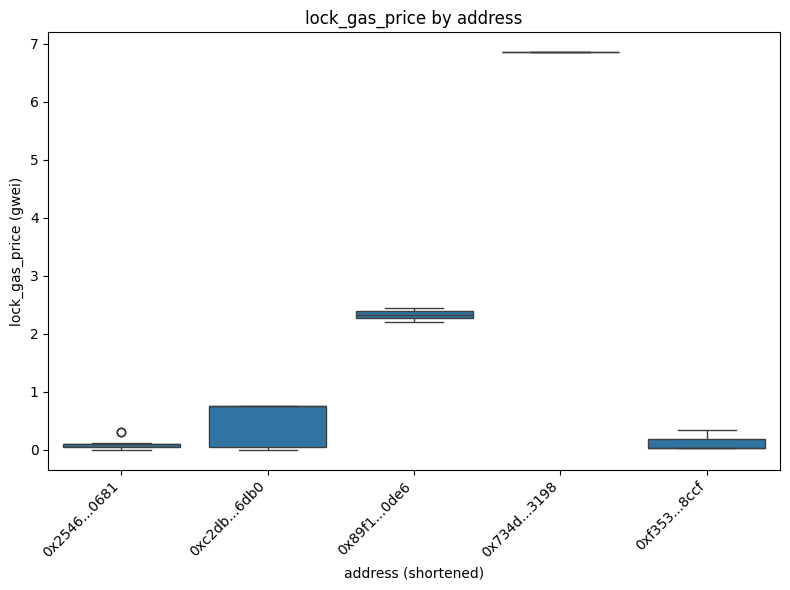

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame([
    {"address": addr, "order_id": oid, "lock_txn": txn, "lock_gas_price": float(gas)}
    for addr, lst in data_dict.items()
    for oid, txn, gas in lst
])

from dc_view import plot_gas_price_boxplot, compute_gas_group_stats, filter_good_suppliers

print("Group stats:")
group_stats = compute_gas_group_stats(df)
print(group_stats)

print("Good suppliers:")
good = filter_good_suppliers(group_stats, min_count=10, max_std=5)
print(good)

print("Gas price boxplot:")
plot_gas_price_boxplot(df)